In [ ]:
import pandas as pd

# Output file
output_file = "merged_output.csv"

# Initialize empty list to hold dataframes
dfs = []

for i in range(1, 241):  # 1 to 240
    filename = f"{i}.csv"
    try:
        df = pd.read_csv(filename)
        dfs.append(df)
    except FileNotFoundError:
        print(f"File {filename} not found, skipping...")

# Concatenate all dataframes
merged_df = pd.concat(dfs, ignore_index=True)

# Save to CSV
merged_df.to_csv(output_file, index=False)

print(f"Merged 1–240 into {output_file}")


Merged 1–240 into merged_output.csv


In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.svm import OneClassSVM, SVC
import matplotlib.pyplot as plt
from scipy import stats
import json
path = "1.csv"
if not os.path.exists(path):
    raise FileNotFoundError(path + " not found. Place 1.csv in the working directory.")

import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Outlier inspection and missing-value imputation
df=pd.read_csv("merged_output.csv")
pd.options.display.width = 200
pd.options.display.max_columns = 60
print("Loaded", path, "shape:", df.shape)
print("Columns and types:")
print(df.dtypes)
print("\nMissing per column:\n", df.isna().sum())
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
print("Numeric columns:", num_cols)
if len(num_cols) == 0:
    raise ValueError("No numeric columns found. Anomaly detection requires numeric data.")
df_num = df[num_cols].copy()
print("\nNumeric summary:")
print(df_num.describe().T)


Loaded 1.csv shape: (72000, 7)
Columns and types:
Body_Temperature    float64
Heart_Rate            int64
Pulse_Rate            int64
SpO2                  int64
ECG                   int64
Anomaly_Type          int64
Normal                int64
dtype: object

Missing per column:
 Body_Temperature    0
Heart_Rate          0
Pulse_Rate          0
SpO2                0
ECG                 0
Anomaly_Type        0
Normal              0
dtype: int64
Numeric columns: ['Body_Temperature', 'Heart_Rate', 'Pulse_Rate', 'SpO2', 'ECG', 'Anomaly_Type', 'Normal']

Numeric summary:
                    count        mean         std   min     25%     50%     75%    max
Body_Temperature  72000.0   99.064116   18.306142  50.0   97.16   98.12   99.66  150.0
Heart_Rate        72000.0   74.471042   28.434806   0.0   63.00   73.00   87.00  149.0
Pulse_Rate        72000.0   74.670806   28.541059   0.0   63.00   73.00   87.00  149.0
SpO2              72000.0   77.638819   29.464647   0.0   62.00   95.00   97.0

In [ ]:
zscore_thresh = 4.0
z = np.abs(stats.zscore(df_num.fillna(df_num.mean())))
outlier_rows = (z > zscore_thresh).any(axis=1).sum()
print(f"Rows with any z-score > {zscore_thresh}: {outlier_rows}")
df_clean = df_num.copy()
for c in df_clean.columns:
    if df_clean[c].isna().sum() > 0:
        df_clean[c].fillna(df_clean[c].median(), inplace=True)


Rows with any z-score > 4.0: 0


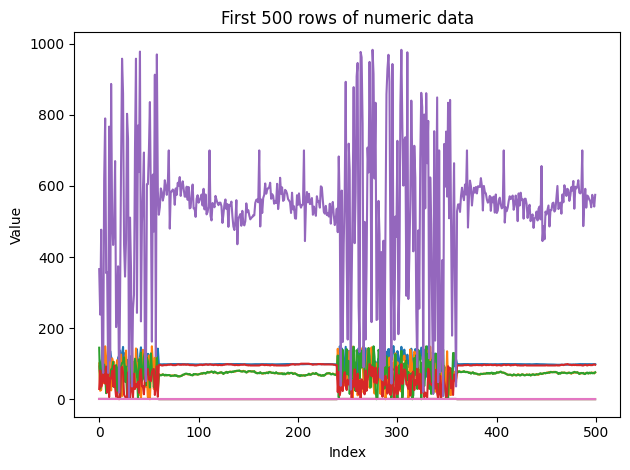

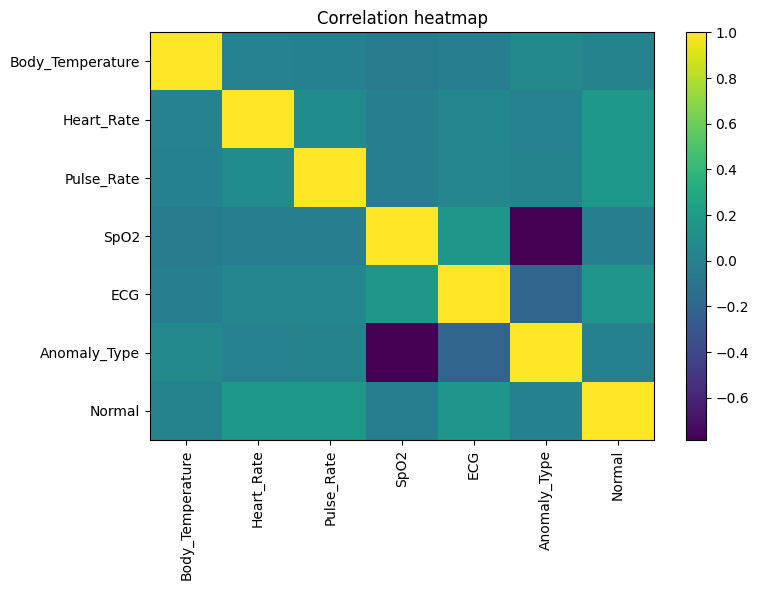

In [ ]:
plt.figure()
plt.plot(df_clean.values[:min(500, len(df_clean))])
plt.title("First 500 rows of numeric data")
plt.xlabel("Index")
plt.ylabel("Value")
plt.tight_layout()
plt.show()


corr = df_clean.corr()
plt.figure(figsize=(8,6))
plt.imshow(corr, aspect='auto')
plt.colorbar()
plt.title("Correlation heatmap")
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.tight_layout()

plt.show()

In [ ]:
possible_label_names = ['label','anomaly','is_anomaly','target','y','class']
label_col = None
cols_lower = {c.lower():c for c in df.columns}
for name in possible_label_names:
    if name in cols_lower:
        label_col = cols_lower[name]
        break
if label_col is not None:
    print("Detected label column:", label_col)
    labels = df[label_col].values
    if labels.dtype == object:
        labels = pd.factorize(labels)[0]
else:
    print("No label column found. Proceeding unsupervised One-Class SVM.")
scaler = StandardScaler()
X = scaler.fit_transform(df_clean.values)
y = labels if 'labels' in locals() else None
os.makedirs("outputs", exist_ok=True)


No label column found. Proceeding unsupervised One-Class SVM.


In [ ]:
#Hyperparameter search for One-Class SVM on a subsample
param_grid = {'nu':[0.001,0.005,0.01,0.02,0.05,0.1], 'gamma':[0.001,0.005,0.01,0.05,0.1,'scale']}
sub_frac = 0.1
rng = np.random.default_rng(42)
idx_sub = rng.choice(len(X), size=max(1000, int(len(X)*sub_frac)), replace=False)
X_sub = X[idx_sub]
best = None
best_diff = None
target_frac = 0.02
for nu in param_grid['nu']:
    for gamma in param_grid['gamma']:
        try:
            m = OneClassSVM(kernel='rbf', nu=nu, gamma=gamma)
            m.fit(X_sub)
            preds = m.predict(X_sub)
            frac = (preds == -1).mean()
            diff = abs(frac - target_frac)
            if best is None or diff < best_diff:
                best = (nu, gamma)
                best_diff = diff
        except Exception:
            continue
nu_best, gamma_best = best
print("Selected subsample params:", nu_best, gamma_best, "approx anomaly frac:", 1 - best_diff)


Selected subsample params: 0.02 0.05 approx anomaly frac: 1.0


In [ ]:
#Fit final One-Class SVM on full dataset and flag anomalies
ocsvm = OneClassSVM(kernel='rbf', nu=nu_best, gamma=gamma_best)
ocsvm.fit(X)
preds_full = ocsvm.predict(X)
df['ocsvm_anomaly'] = (preds_full == -1).astype(int)
print("One-Class SVM detected anomalies:", df['ocsvm_anomaly'].sum())
df.to_csv("outputs/with_ocsvm_flags.csv", index=False)


One-Class SVM detected anomalies: 1443


In [ ]:
#Sequence creation for LSTM
seq_len = 30
def create_sequences(data, seq_len):
    n = data.shape[0]
    return np.array([data[i:i+seq_len] for i in range(n - seq_len + 1)])
seq_data = create_sequences(X, seq_len)
if seq_data.shape[0] == 0:
    raise ValueError("Sequence length too long for dataset; reduce seq_len.")
if y is not None:
    seq_labels = np.array([y[i + seq_len//2] for i in range(len(y) - seq_len + 1)])
else:
    oc_flags = df['ocsvm_anomaly'].values
    seq_labels = np.array([oc_flags[i + seq_len//2] for i in range(len(oc_flags) - seq_len + 1)])
X_train, X_val, y_train, y_val = train_test_split(seq_data, seq_labels, test_size=0.2, shuffle=False)


In [ ]:
#Build multi-task LSTM (shared encoder, reconstruction + classifier)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

inp = Input(shape=(seq_len, X_train.shape[2]))
x = LSTM(64, return_sequences=False)(inp)
shared = Dense(32, activation='relu')(x)
clf_out = Dense(1, activation='sigmoid', name='anomaly_out')(shared)
rep = RepeatVector(seq_len)(shared)
dec = LSTM(64, return_sequences=True)(rep)
recon_out = TimeDistributed(Dense(X_train.shape[2]), name='recon_out')(dec)
model = Model(inputs=inp, outputs=[recon_out, clf_out])
model.compile(optimizer=Adam(0.001),
              loss={'recon_out':'mse','anomaly_out':'binary_crossentropy'},
              loss_weights={'recon_out':1.0,'anomaly_out':1.0},
              metrics={'anomaly_out':['accuracy']})


In [ ]:
#Train the multi-task LSTM with early stopping
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, {'recon_out':X_train, 'anomaly_out':y_train},
                    validation_data=(X_val, {'recon_out':X_val, 'anomaly_out':y_val}),
                    epochs=30, batch_size=128, callbacks=[es], verbose=1)


Epoch 1/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - anomaly_out_accuracy: 0.9825 - anomaly_out_loss: 0.0712 - loss: 0.5933 - recon_out_loss: 0.5221 - val_anomaly_out_accuracy: 0.9671 - val_anomaly_out_loss: 0.1192 - val_loss: 0.6886 - val_recon_out_loss: 0.5727
Epoch 2/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 41s 91ms/step - anomaly_out_accuracy: 0.9833 - anomaly_out_loss: 0.0690 - loss: 0.5931 - recon_out_loss: 0.5241 - val_anomaly_out_accuracy: 0.9671 - val_anomaly_out_loss: 0.1184 - val_loss: 0.6927 - val_recon_out_loss: 0.5776
Epoch 3/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 42s 92ms/step - anomaly_out_accuracy: 0.9830 - anomaly_out_loss: 0.0698 - loss: 0.5972 - recon_out_loss: 0.5274 - val_anomaly_out_accuracy: 0.9671 - val_anomaly_out_loss: 0.1203 - val_loss: 0.6996 - val_recon_out_loss: 0.5826
Epoch 4/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 42s 93ms/step - anomaly_out_accuracy: 0.9831 - anomaly_out_loss: 0.0695 - loss: 0.5886 - recon_out_loss: 0.5191 - val_anomaly_out_accuracy: 0.9671 - val_anomaly_

In [ ]:
#Evaluate classifier head and reconstruction-based anomaly scoring
recon_pred, clf_pred = model.predict(X_val)
clf_bin = (clf_pred.ravel() >= 0.5).astype(int)
print("LSTM classifier report:\n", classification_report(y_val, clf_bin))
cm = confusion_matrix(y_val, clf_bin)
print("Confusion matrix:\n", cm)
recon_error = np.mean((recon_pred - X_val)**2, axis=(1,2))
threshold = np.percentile(recon_error, 95)
auto_anom = recon_error > threshold
print("Reconstruction-based anomalies (val):", auto_anom.sum())


450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step
LSTM classifier report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     13922
           1       0.00      0.00      0.00       473

    accuracy                           0.97     14395
   macro avg       0.48      0.50      0.49     14395
weighted avg       0.94      0.97      0.95     14395

Confusion matrix:
 [[13922     0]
 [  473     0]]
Reconstruction-based anomalies (val): 720


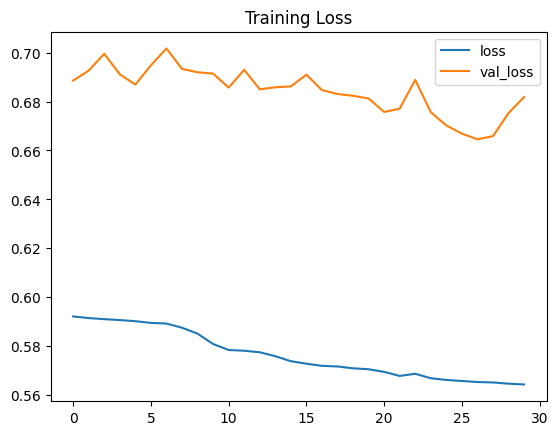

In [ ]:
plt.figure()
plt.plot(history.history.get('loss', []), label='loss')
plt.plot(history.history.get('val_loss', []), label='val_loss')
plt.legend()
plt.title("Training Loss")
plt.show()


model.save("outputs/lstm_multitask_model.h5")
np.save("outputs/scaler_mean.npy", scaler.mean_)
np.save("outputs/scaler_scale.npy", scaler.scale_)
df.to_csv("outputs/final_with_flags.csv", index=False)


In [ ]:
print("Sequences:", seq_data.shape)
print("Train sequences:", X_train.shape, "Val sequences:", X_val.shape)
print("Total anomalies (One-Class SVM):", df['ocsvm_anomaly'].sum())


Sequences: (71971, 30, 7)
Train sequences: (57576, 30, 7) Val sequences: (14395, 30, 7)
Total anomalies (One-Class SVM): 1443
